# Drug Molecule Generation with VAE

## Setup

RDKit is an open source toolkit for cheminformatics and machine learning. This toolkit come in handy
if one is into drug discovery domain. In this example, RDKit is used to conveniently
and efficiently transform SMILES to molecule objects, and then from those obtain sets of atoms
and bonds.

Quoting from
[WGAN-GP with R-GCN for the generation of small molecular graphs](https://keras.io/examples/generative/wgan-graphs/)):

**"SMILES expresses the structure of a given molecule in the form of an ASCII string.
The SMILES string is a compact encoding which, for smaller molecules, is relatively human-readable.
Encoding molecules as a string both alleviates and facilitates database and/or web searching
of a given molecule. RDKit uses algorithms to accurately transform a given SMILES to
a molecule object, which can then be used to compute a great number of molecular properties/features."**

In [ ]:
%pip -q install rdkit-pypi==2021.9.4

In [ ]:
import ast

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage

RDLogger.DisableLog("rdApp.*")

## Dataset

We use the [**ZINC – A Free Database of Commercially Available Compounds for
Virtual Screening**](https://bit.ly/3IVBI4x) dataset. The dataset comes with molecule
formula in SMILE representation along with their respective molecular properties such as
**logP** (water–octanal partition coefficient), **SAS** (synthetic
accessibility score) and **QED** (Qualitative Estimate of Drug-likeness).

In [ ]:
csv_path = keras.utils.get_file(
    "/content/250k_rndm_zinc_drugs_clean_3.csv",
    "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv",
)

df = pd.read_csv("/content/250k_rndm_zinc_drugs_clean_3.csv")
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))
df.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


## Hyperparameters

In [ ]:
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br"]'

bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3}
bond_mapping.update(
    {0: BondType.SINGLE, 1: BondType.DOUBLE, 2: BondType.TRIPLE, 3: BondType.AROMATIC}
)
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

MAX_MOLSIZE = max(df["smiles"].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

BATCH_SIZE = 100
EPOCHS = 10

VAE_LR = 5e-4
NUM_ATOMS = 120  # Maximum number of atoms

ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 435  # Size of the latent space


def smiles_to_graph(smiles):
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


def graph_to_molecule(graph):
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule


##  Generate training set

In [ ]:
train_df = df.sample(frac=0.75, random_state=42)  # random state is a seed value
train_df.reset_index(drop=True, inplace=True)

adjacency_tensor, feature_tensor, qed_tensor = [], [], []
for idx in range(8000):
    adjacency, features = smiles_to_graph(train_df.loc[idx]["smiles"])
    qed = train_df.loc[idx]["qed"]
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)
    qed_tensor.append(qed)

adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)
qed_tensor = np.array(qed_tensor)

## R-GCN Layer

In [ ]:
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)


## Quantum Dense Layer

### Some Imports

In [ ]:
%pip -q install qiskit

In [ ]:
import datetime
import qiskit
from qiskit import transpile, assemble, QuantumRegister, QuantumCircuit
from qiskit.providers.ibmq import least_busy
from qiskit.providers.ibmq.job import job_monitor
from qiskit.tools import backend_monitor
from dataclasses import dataclass

### QCM

In [ ]:
class QiskitCircuitModule:
    def __init__(self, qubits=3, instructions=None, shots=1):
        self.qubit_num = qubits
        self.instructions = instructions
        if not self.instructions: self.instructions = self.null_circuit(self.qubit_num)
        self.probabilities = tf.constant([[0.5] * self.qubit_num])
        self.phase_probabilities = tf.constant([1] * self.qubit_num)
        self.layer = self.superposition_qubits(self.probabilities, self.phase_probabilities)
        self.layer.append(self.instructions, range(self.qubit_num))
        self.layer.measure_all()
        self.backend = qiskit.Aer.get_backend('aer_simulator')
        self.shots = shots


    def p_to_angle(self, p):
        angle = 2 * np.arccos(np.sqrt(p))
        return angle

    def superposition_qubits(self, probabilities: tf.Tensor, phases: tf.Tensor):
        layer = qiskit.QuantumCircuit(self.qubit_num)
        reshaped_probabilities = tf.reshape(probabilities, [self.qubit_num])
        reshaped_phases = tf.reshape(phases, [self.qubit_num])
        static_probabilities = tf.get_static_value(reshaped_probabilities[:])
        static_phases = tf.get_static_value(reshaped_phases[:])
        try: _ = len(static_probabilities)
        except TypeError: static_probabilities = [np.random.random() for _ in range(self.qubit_num)]
        try: _ = len(static_phases)
        except TypeError: static_phases = [np.random.random() for _ in range(self.qubit_num)]
        for ix, p in enumerate(static_probabilities):
            p = np.abs(p)
            theta = self.p_to_angle(p)
            phi = self.p_to_angle(static_phases[ix])
            layer.u(theta, phi, 0, ix)
        return layer

    def quantum_execute(self, probabilities, phases):
        self.layer = self.superposition_qubits(probabilities, phases)
        self.layer.append(self.instructions, range(self.qubit_num))
        self.layer.measure_all()
        transpiled_circuit = transpile(self.layer, self.backend)
        quantum_job_object = assemble(transpiled_circuit, shots=self.shots)
        quantum_job = self.backend.run(quantum_job_object)
        job_monitor(quantum_job)
        result = quantum_job.result().get_counts()

        qubit_set_probabilities = self.calculate_qubit_set_probabilities(result)
        return qubit_set_probabilities

    def calculate_qubit_set_probabilities(self, quantum_job_result):
        qubit_set_probabilities = [0] * self.qubit_num
        for state_result, count in quantum_job_result.items():
            for ix, q in enumerate(state_result):
                if q == '1':
                    qubit_set_probabilities[ix] += count
        sum_counts = sum(qubit_set_probabilities)
        if not sum_counts == 0:
            qubit_set_probabilities = [i/sum_counts for i in qubit_set_probabilities]
        return qubit_set_probabilities

    def null_circuit(self, qubits):
        gate_register = QuantumRegister(qubits, 'q')
        gate_circuit = QuantumCircuit(gate_register, name='sub_circuit')
        gate_instructions = gate_circuit.to_instruction()
        return gate_instructions


### Quantum Dense

In [ ]:
class QuantumLayer(keras.layers.Layer):
    def __init__(self, qubits=16, instructions=None, shots=1, use_parameter_shift_gradient_flow=False):
        super(QuantumLayer, self).__init__()
        self.use_parameter_shift_gradient_flow = use_parameter_shift_gradient_flow
        self.qubits = qubits
        self.instructions = instructions
        self.tensor_history = []
        self.shots = shots
        self.circuit = QiskitCircuitModule(self.qubits, instructions=self.instructions, shots=self.shots)

    def build(self, input_shape):
        kernel_p_initialisation = tf.random_normal_initializer()
        self.kernel_p = tf.Variable(name="kernel_p", initial_value=kernel_p_initialisation(shape=(input_shape[-1], self.qubits), dtype='float32'), trainable=True)
        kernel_phi_initialisation = tf.zeros_initializer()
        self.kernel_phi = tf.Variable(name="kernel_phi", initial_value=kernel_phi_initialisation(shape=(self.qubits,), dtype='float32'), trainable=False)

    def call(self, inputs):
        if not self.use_parameter_shift_gradient_flow:
            output = tf.matmul(inputs, self.kernel_p)
            try: _ = tf.reshape(output, [1, self.qubits])
            except ValueError:
                #print(output, output.shape)
                factor = output.shape[0] * output.shape[1]
                output = tf.reshape(output, [factor])
                output = tf.slice(output, [0], [self.qubits])
                #raise RuntimeError("Debugging in Progress -- Execution Stopped")
            qubit_output = self.circuit.quantum_execute(tf.reshape(output, [1, self.qubits]), self.kernel_phi)
            qubit_output = tf.reshape(tf.convert_to_tensor(qubit_output, dtype=tf.float32), (1, self.qubits))
            output += (qubit_output - output)
        else: output = self.quantum_flow(inputs)
        return output

    @tf.custom_gradient
    def quantum_flow(self, x):
        output = tf.matmul(x, self.kernel_p)
        qubit_output = tf.reshape(tf.convert_to_tensor(self.circuit.quantum_execute(tf.reshape(output, [1, self.qubits]), self.kernel_phi)), (1, 1, self.qubits))
        output = qubit_output
        def grad(dy, variables=None):
            shift = np.pi / 2
            shift_right = x + np.ones(x.shape) * shift
            shift_left = x - np.ones(x.shape) * shift
            input_left = tf.matmul(shift_left, self.kernel_p)
            input_right = tf.matmul(shift_right, self.kernel_p)
            output_right = self.circuit.quantum_execute(tf.reshape(input_right, [1, self.qubits]), self.kernel_phi)
            output_left = self.circuit.quantum_execute(tf.reshape(input_left, [1, self.qubits]), self.kernel_phi)
            quantum_gradient = [output_right[i] - output_left[i] for i in range(len(output_right))]
            input_gradient = dy * quantum_gradient
            dy_input_gradient = tf.reshape(tf.matmul(input_gradient, tf.transpose(self.kernel_p)), shape=[1, 1, x.get_shape().as_list()[-1]])
            grd_w = []
            for i in range(self.qubits):
                w = self.kernel_p[:, i]
                w += dy_input_gradient
                grd_w.append(w)
            tf_grd_w = tf.convert_to_tensor(grd_w)
            tf_grd_w = tf.reshape(tf_grd_w, shape=(x.get_shape().as_list()[-1], self.qubits))
            return dy_input_gradient, [tf_grd_w]
        return output, grad

### Goober

In [ ]:
chink = QuantumLayer(16)

In [ ]:
x = [1.9147, 1.9134, 1.9126, 1.9125, 1.8205, 1.8201, 1.8187, 1.8172, 1.8154, 1.8138, 1.8109, 7.503, 1.6137, 1.6117, .9588, .9587]

In [ ]:
sus = tf.constant([x])

In [ ]:
sus

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[1.9147, 1.9134, 1.9126, 1.9125, 1.8205, 1.8201, 1.8187, 1.8172,
        1.8154, 1.8138, 1.8109, 7.503 , 1.6137, 1.6117, 0.9588, 0.9587]],
      dtype=float32)>

In [ ]:
wtf = chink(sus)

<ipython-input-9-2b5edcf16885>:42: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  quantum_job = self.backend.run(quantum_job_object)


Job Status: job has successfully run


In [ ]:
wtf

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[0.        , 0.1111111 , 0.        , 0.1111111 , 0.1111111 ,
        0.        , 0.1111111 , 0.1111111 , 0.1111111 , 0.        ,
        0.1111111 , 0.11111111, 0.        , 0.        , 0.        ,
        0.1111111 ]], dtype=float32)>

## Build the Sampling layer

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_log_var)[0]
        dim = tf.shape(z_log_var)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Build the Encoder and Decoder

The Encoder takes as input a molecule's graph adjacency matrix and feature matrix.
These features are processed via a Graph Convolution layer, then are flattened and
processed by several Dense layers to derive `z_mean` and `log_var`, the
latent-space representation of the molecule.

**Graph Convolution layer**: The relational graph convolution layer implements
non-linearly transformed neighbourhood aggregations. We can define these layers as
follows:

`H_hat**(l+1) = σ(D_hat**(-1) * A_hat * H_hat**(l+1) * W**(l))`

Where `σ` denotes the non-linear transformation (commonly a ReLU activation), `A` the
adjacency tensor, `H_hat**(l)` the feature tensor at the `l-th` layer, `D_hat**(-1)` the
inverse diagonal degree tensor of `A_hat`, and `W_hat**(l)` the trainable weight tensor
at the `l-th` layer. Specifically, for each bond type (relation), the degree tensor
expresses, in the diagonal, the number of bonds attached to each atom.

Source:
[WGAN-GP with R-GCN for the generation of small molecular graphs](https://keras.io/examples/generative/wgan-graphs/))

The Decoder takes as input the latent-space representation and predicts
the graph adjacency matrix and feature matrix of the corresponding molecules.

### Encoder

In [ ]:
def get_encoder(gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units, dropout_rate, quantum=False):
    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)([adjacency, features_transformed])
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)
    for units in dense_units:
        if quantum:
            ql = QuantumLayer(qubits=units, shots=1, use_parameter_shift_gradient_flow=False)
            x = ql(x, training=True)
        else:
            x = layers.Dense(units, activation="tanh")(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(dropout_rate)(x)
    z_mean = layers.Dense(latent_dim, dtype="float32", name="z_mean")(x)
    log_var = layers.Dense(latent_dim, dtype="float32", name="log_var")(x)
    encoder = keras.Model([adjacency, features], [z_mean, log_var], name="encoder")
    return encoder

In [ ]:
qencoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[16],
    dropout_rate=0.2,
    quantum=True
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'qregs' can't be nonlocal (__autograph_generated_fileq6sf4wwt.py, line 90)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'qregs' can't be nonlocal (__autograph_generated_fileq6sf4wwt.py, line 90)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Job Status: job has successfully run
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
qencoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 120, 120  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 120, 11)]    0           []                               
                                                                                                  
 relational_graph_conv_layer (R  (None, 120, 9)      495         ['input_1[0][0]',                
 elationalGraphConvLayer)                                         'input_2[0][0]']                
                                                                                            

#### Non-Quantum For Comparison

In [ ]:
encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[16],
    dropout_rate=0.2,
    quantum=False
)

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5, 120, 120  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 120, 11)]    0           []                               
                                                                                                  
 relational_graph_conv_layer_1   (None, 120, 9)      495         ['input_3[0][0]',                
 (RelationalGraphConvLayer)                                       'input_4[0][0]']                
                                                                                            

### Decoder

In [ ]:
def get_decoder(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = latent_inputs
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    x_adjacency = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape))(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    x_adjacency = (x_adjacency + tf.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)
    x_features = keras.layers.Dense(tf.math.reduce_prod(feature_shape))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)
    decoder = keras.Model(latent_inputs, outputs=[x_adjacency, x_features], name="decoder")
    return decoder

In [ ]:
decoder = get_decoder(
    dense_units=[16],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

In [ ]:
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 435)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 16)           6976        ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 16)           0           ['dense_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 72000)        1224000     ['dropout_2[0][0]']              
                                                                                            

## Build the VAE

This model is trained to optimize four losses:

* Categorical crossentropy
* KL divergence loss
* Property prediction loss
* Graph loss (gradient penalty)

The categorical crossentropy loss function measures the model's
reconstruction accuracy. The Property prediction loss estimates the mean squared
error between predicted and actual properties after running the latent representation
through a property prediction model. The property
prediction of the model is optimized via binary crossentropy. The gradient
penalty is further guided by the model's property (QED) prediction.

A gradient penalty is an alternative soft constraint on the
1-Lipschitz continuity as an improvement upon the gradient clipping scheme from the
original neural network
("1-Lipschitz continuity" means that the norm of the gradient is at most 1 at evey single
point of the function).
It adds a regularization term to the loss function.

In [ ]:
class MoleculeGenerator(keras.Model):
    def __init__(self, encoder, decoder, max_len, quantum=False, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.property_prediction_layer = layers.Dense(1)
        self.max_len = max_len
        self.train_total_loss_tracker = keras.metrics.Mean(name="train_total_loss")
        self.val_total_loss_tracker = keras.metrics.Mean(name="val_total_loss")
        self.quantum = quantum

    def train_step(self, data):
        adjacency_tensor, feature_tensor, qed_tensor = data[0]
        graph_real = [adjacency_tensor, feature_tensor]
        self.batch_size = tf.shape(qed_tensor)[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, qed_pred, gen_adjacency, gen_features = self(graph_real, training=True)
            graph_generated = [gen_adjacency, gen_features]
            total_loss = self._compute_loss(z_log_var, z_mean, qed_tensor, qed_pred, graph_real, graph_generated)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.train_total_loss_tracker.update_state(total_loss)
        return {"loss": self.train_total_loss_tracker.result()}

    def _compute_loss(self, z_log_var, z_mean, qed_true, qed_pred, graph_real, graph_generated):
        adjacency_real, features_real = graph_real
        adjacency_gen, features_gen = graph_generated

        if self.quantum:
            #QUANTUM ONLY
            adjacency_gen = tf.stack([adjacency_gen for _ in range(32)]) #quantum only
            adjacency_gen = tf.reshape(adjacency_gen, (32, 5, 120, 120)) #quantum only
            features_gen = tf.stack([features_gen for _ in range(32)]) #quantum only
            features_gen = tf.reshape(features_gen, (32, 120, 11))
            #END QUANTUM ONLY

        #print(adjacency_real, adjacency_gen)
        #raise RuntimeError("Debugging in Progress -- Execution Stopped")
        adjacency_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.categorical_crossentropy(adjacency_real, adjacency_gen), axis=(1, 2),))
        features_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.categorical_crossentropy(features_real, features_gen), axis=(1),))
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), 1)
        kl_loss = tf.reduce_mean(kl_loss)
        property_loss = tf.reduce_mean(keras.losses.binary_crossentropy(qed_true, qed_pred))
        graph_loss = self._gradient_penalty(graph_real, graph_generated)
        return kl_loss + property_loss + graph_loss + adjacency_loss + features_loss

    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated
        # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated
        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            _, _, logits, _, _ = self([adjacency_interp, features_interp], training=True)
        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1)) + tf.reduce_mean(grads_features_penalty, axis=(-1)))

    def inference(self, batch_size):
        z = tf.random.normal((batch_size, LATENT_DIM))
        reconstruction_adjacency, reconstruction_features = model.decoder.predict(z)
        # obtain one-hot encoded adjacency tensor
        adjacency = tf.argmax(reconstruction_adjacency, axis=1)
        adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
        # Remove potential self-loops from adjacency
        adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
        # obtain one-hot encoded feature tensor
        features = tf.argmax(reconstruction_features, axis=2)
        features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
        return [graph_to_molecule([adjacency[i].numpy(), features[i].numpy()]) for i in range(batch_size)]

    def call(self, inputs):
        z_mean, log_var = self.encoder(inputs)
        z = Sampling()([z_mean, log_var])
        gen_adjacency, gen_features = self.decoder(z)
        property_pred = self.property_prediction_layer(z_mean)
        return z_mean, log_var, property_pred, gen_adjacency, gen_features


In [ ]:
vae_optimizer = tf.keras.optimizers.Adam(learning_rate=VAE_LR)

## Train the model

### Quantum

In [ ]:
model = MoleculeGenerator(encoder, decoder, MAX_MOLSIZE, quantum=False)
model.compile(vae_optimizer)
history = model.fit([adjacency_tensor, feature_tensor, qed_tensor], epochs=10)

Epoch 1/10
250/250 [==============================] - 80s 306ms/step - loss: nan
Epoch 2/10
250/250 [==============================] - 68s 272ms/step - loss: nan
Epoch 3/10
250/250 [==============================] - 73s 293ms/step - loss: nan
Epoch 4/10
250/250 [==============================] - 70s 282ms/step - loss: nan
Epoch 5/10
250/250 [==============================] - 71s 282ms/step - loss: nan
Epoch 6/10
250/250 [==============================] - 68s 272ms/step - loss: nan
Epoch 7/10
250/250 [==============================] - 74s 297ms/step - loss: nan
Epoch 8/10
250/250 [==============================] - 68s 273ms/step - loss: nan
Epoch 9/10
250/250 [==============================] - 71s 284ms/step - loss: nan
Epoch 10/10
250/250 [==============================] - 69s 277ms/step - loss: nan


## Inference

We use our model to generate new valid molecules from different points of the latent space.

### Generate unique Molecules with the model

In [ ]:
molecules = model.inference(84)

3/3 [==============================] - 0s 51ms/step


### Display latent space clusters with respect to molecular properties (QAE)

3/3 [==============================] - 0s 7ms/step


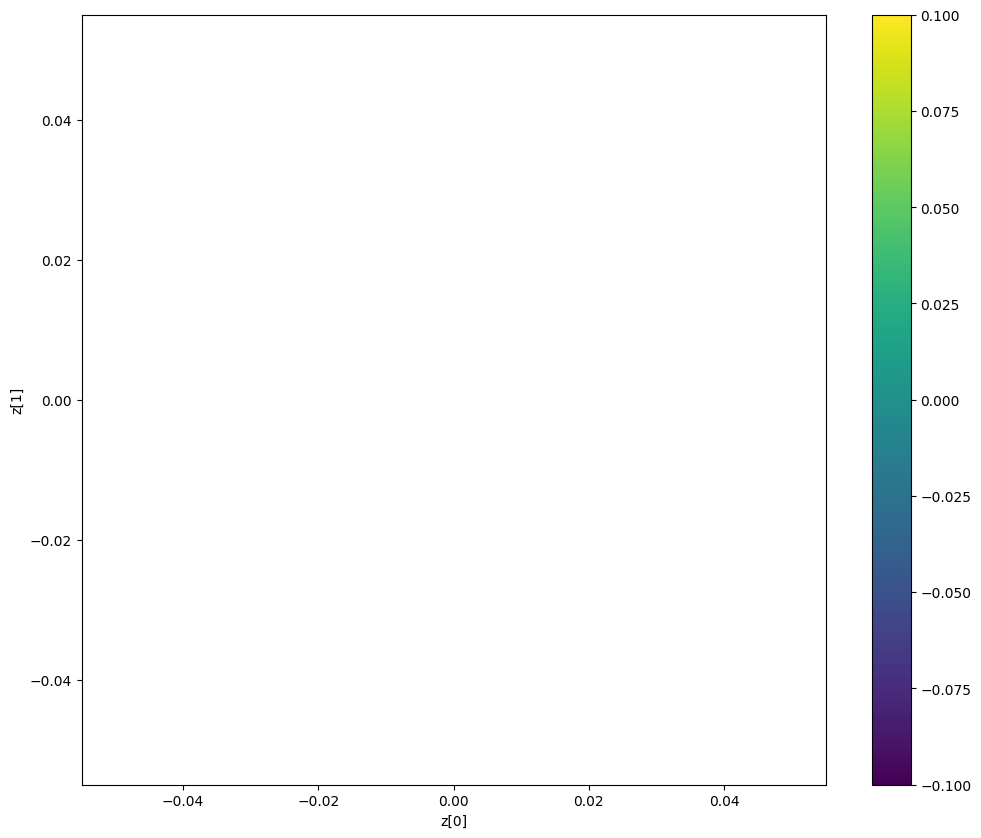

In [ ]:
def plot_latent(vae, data, labels):
    # display a 2D plot of the property in the latent space
    z_mean, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


plot_latent(model, [adjacency_tensor[:84], feature_tensor[:84]], qed_tensor[:84])